# Machine Learning Foundation

## Course 4, Part c: Dimensionality Reduction DEMO

## Introduction

We will be using customer data from a [Portuguese wholesale distributor](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers) for clustering. This data file is called `Wholesale_Customers_Data`.

It contains the following features:

* Fresh: annual spending (m.u.) on fresh products
* Milk: annual spending (m.u.) on milk products
* Grocery: annual spending (m.u.) on grocery products
* Frozen: annual spending (m.u.) on frozen products
* Detergents_Paper: annual spending (m.u.) on detergents and paper products
* Delicatessen: annual spending (m.u.) on delicatessen products
* Channel: customer channel (1: hotel/restaurant/cafe or 2: retail)
* Region: customer region (1: Lisbon, 2: Porto, 3: Other)

In this data, the values for all spending are given in an arbitrary unit (m.u. = monetary unit).

In [1]:
import os, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from colorsetup import colors, palette
sns.set_palette(palette)

## Part 1

In this section, we will:

* Import the data and check the data types.
* Drop the channel and region columns as they won't be used since we focus on numeric columns for this example.
* Convert the remaining columns to floats if necessary.
* Copy this version of the data (using the `copy` method) to a variable to preserve it. We will be using it later.

In [2]:
df = pd.read_csv('Wholesale_Customers_Data.csv', sep=',')

In [3]:
df.shape

(440, 8)

In [4]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df = df.drop(['Channel', 'Region'], axis=1)

In [6]:
df.dtypes

Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [8]:
# Convert to floats
for col in df.columns:
    df[col] = df[col].astype(float)

Preserve the original data.

In [9]:
df_orig = df.copy()

## Part 2

As with the previous lesson, we need to ensure the data is scaled and (relatively) normally distributed.

* Examine the correlation and skew.
* Perform any transformations and scale data using your favorite scaling method.
* View the pairwise correlation plots of the new data.

In [11]:
corr_matrix = df.corr()

# Strip the diagonal for future examination
for x in range(corr_matrix.shape[0]):
    corr_matrix.iloc[x,x] = 0.0
    
corr_matrix

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,0.000000,0.100354,-0.010922,0.346594,-0.102427,0.244748
Milk,0.100354,0.000000,0.726224,0.126640,0.661123,0.405423
Grocery,-0.010922,0.726224,0.000000,-0.038738,0.923400,0.201489
Frozen,0.346594,0.126640,-0.038738,0.000000,-0.130143,0.391148
Detergents_Paper,-0.102427,0.661123,0.923400,-0.130143,0.000000,0.068409
Delicassen,0.244748,0.405423,0.201489,0.391148,0.068409,0.000000


As before, the two categories with their respective most strongly correlated variable.

In [12]:
corr_matrix.abs().idxmax()

Fresh                         Frozen
Milk                         Grocery
Grocery             Detergents_Paper
Frozen                    Delicassen
Detergents_Paper             Grocery
Delicassen                      Milk
dtype: object

Examine the skew values and log transform. Looks like all of them need it.

In [13]:
log_columns = df.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

Delicassen          11.143666
Frozen               5.917209
Milk                 4.056994
Detergents_Paper     3.630067
Grocery              3.583089
Fresh                2.558413
dtype: float64

In [14]:
# The log transformations
for col in log_columns.index:
    df[col] = np.log1p(df[col])

Scale the data again. Let's use `MinMaxScaler` this time just to mix things up.

In [13]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

for col in df.columns:
    df[col] = mms.fit_transform(df[[col]]).squeeze()

Visualize the relationship between the variables.

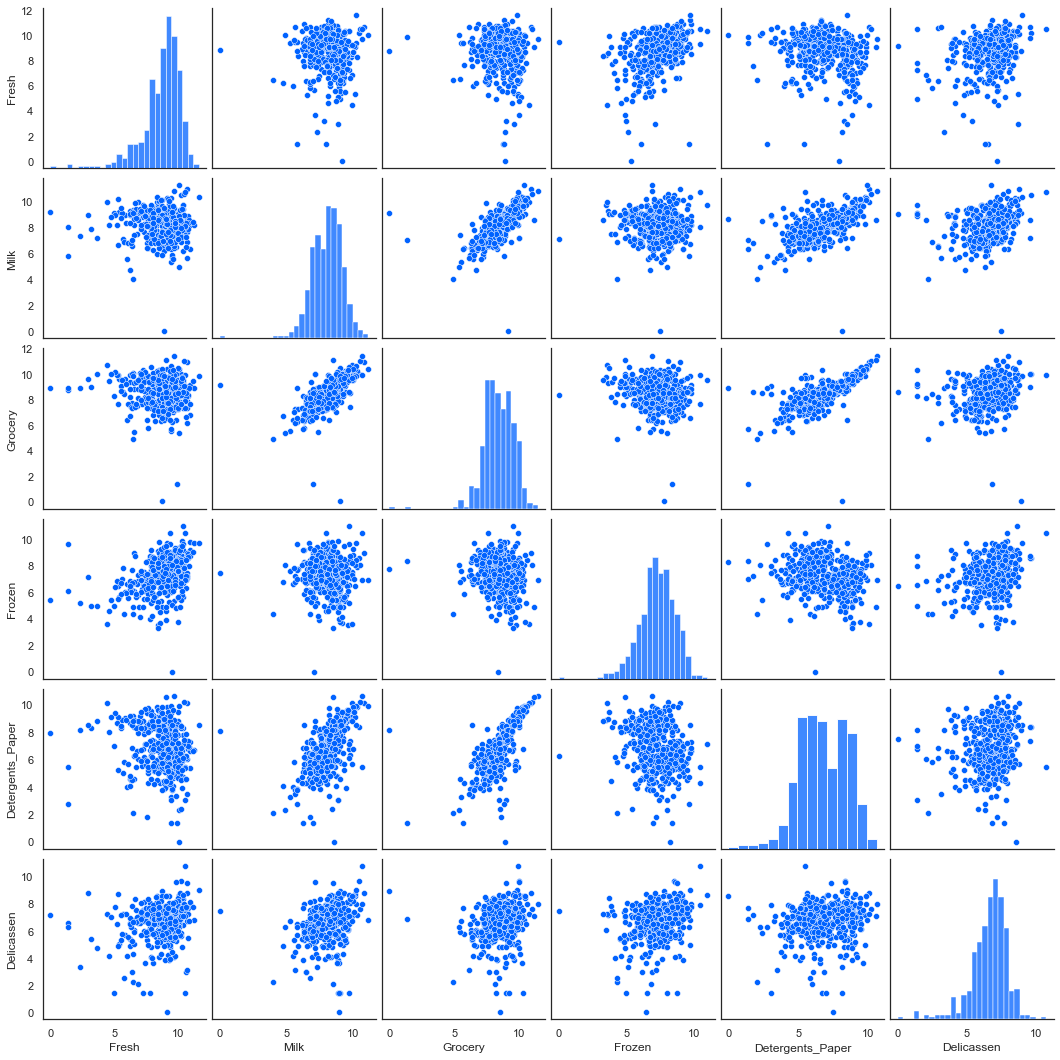

In [15]:
sns.set_context('notebook')
sns.set_style('white')
sns.pairplot(df);

## Part 3

In this section, we will:
* Using Scikit-learn's [pipeline function](http://scikit-learn.org/stable/modules/pipeline.html), recreate the data pre-processing scheme above (transformation and scaling) using a pipeline. If you used a non-Scikit learn function to transform the data (e.g. NumPy's log function), checkout  the custom transformer class called [`FunctionTransformer`](http://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers).
* Use the pipeline to transform the original data that was stored at the end of question 1.
* Compare the results to the original data to verify that everything worked.

*Note:* Scikit-learn has a more flexible `Pipeline` function and a shortcut version called `make_pipeline`. Either can be used. Also, if different transformations need to be performed on the data, a [`FeatureUnion`](http://scikit-learn.org/stable/modules/pipeline.html#featureunion-composite-feature-spaces) can be used.

In [17]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# The custom NumPy log transformer
log_transformer = FunctionTransformer(np.log1p)

# The pipeline
estimators = [('log1p', log_transformer), ('minmaxscale', MinMaxScaler())]
pipeline = Pipeline(estimators)

# Convert the original data
df_pipe = pipeline.fit_transform(df)

The results are identical. Note that machine learning models and grid searches can also be added to the pipeline (and in fact, usually are.)

In [18]:
np.allclose(df_pipe, df)

False

## Part 4

In this section, we will:
* Perform PCA with `n_components` ranging from 1 to 5. 
* Store the amount of explained variance for each number of dimensions.
* Also store the feature importance for each number of dimensions. *Hint:* PCA doesn't explicitly provide this after a model is fit, but the `components_` properties can be used to determine something that approximates importance. How you decided to do so is entirely up to you.
* Plot the explained variance and feature importances.

In [19]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 6):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(df)
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': df.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,PCA(n_components=1),0.419383
2,PCA(n_components=2),0.687101
3,PCA(n_components=3),0.806392
4,PCA(n_components=4),0.905784
5,PCA(n_components=5),0.96246


Create a table of feature importances for each data column.

In [20]:
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

features_df

features,Delicassen,Detergents_Paper,Fresh,Frozen,Grocery,Milk
n,,,,,,
1,0.056404,0.351991,0.102150,0.090875,0.214504,0.184076
2,0.149179,0.199262,0.216751,0.162754,0.132510,0.139544
3,0.211304,0.172282,0.256656,0.156494,0.099645,0.103619
4,0.227441,0.154061,0.227515,0.222959,0.084052,0.083971
5,0.203105,0.182860,0.183625,0.185634,0.103582,0.141194


Create a plot of explained variances.

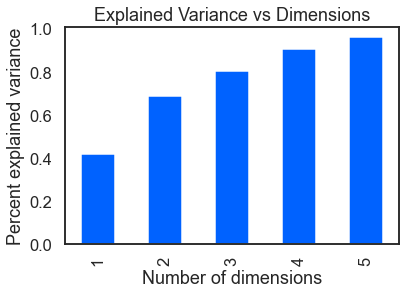

In [21]:
sns.set_context('talk')
ax = pca_df['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions');

And here's a plot of feature importances.

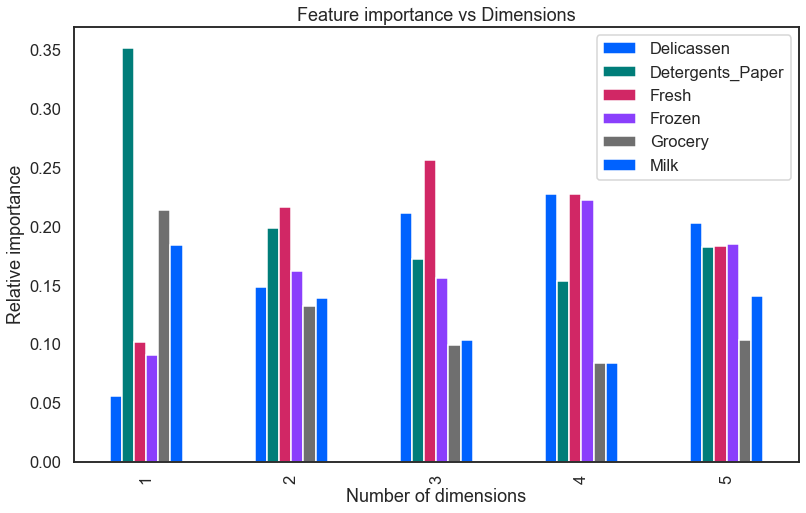

In [22]:
ax = features_df.plot(kind='bar', figsize=(13,8))
ax.legend(loc='upper right')
ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions');

## Part 5

In this section, we will:
* Fit a `KernelPCA` model with `kernel='rbf'`. You can choose how many components and what values to use for the other parameters (`rbf` refers to a Radial Basis Function kernel, and the `gamma` parameter governs scaling of this kernel and typically ranges between 0 and 1). Several other [kernels](https://scikit-learn.org/stable/modules/metrics.html) can be tried, and even passed ss cross validation parameters (see this [example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)).
* If you want to tinker some more, use `GridSearchCV` to tune the parameters of the `KernelPCA` model. 

The second step is tricky since grid searches are generally used for supervised machine learning methods and rely on scoring metrics, such as accuracy, to determine the best model. However, a custom scoring function can be written for `GridSearchCV`, where larger is better for the outcome of the scoring function. 

What would such a metric involve for PCA? What about percent of explained variance? Or perhaps the negative mean squared error on the data once it has been transformed and then inversely transformed?

In [23]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Custom scorer--use negative rmse of inverse transform
def scorer(pcamodel, X, y=None):

    try:
        X_val = X.values
    except:
        X_val = X
        
    # Calculate and inverse transform the data
    data_inv = pcamodel.fit(X_val).transform(X_val)
    data_inv = pcamodel.inverse_transform(data_inv)
    
    # The error calculation
    mse = mean_squared_error(data_inv.ravel(), X_val.ravel())
    
    # Larger values are better for scorers, so take negative value
    return -1.0 * mse

# The grid search parameters
param_grid = {'gamma':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
              'n_components': [2, 3, 4]}

# The grid search
kernelPCA = GridSearchCV(KernelPCA(kernel='rbf', fit_inverse_transform=True),
                         param_grid=param_grid,
                         scoring=scorer,
                         n_jobs=-1)


kernelPCA = kernelPCA.fit(df)

kernelPCA.best_estimator_

KernelPCA(fit_inverse_transform=True, gamma=0.05, kernel='rbf', n_components=4)

## Part 6

Let's explore how our model accuracy may change if we include a `PCA` in our model building pipeline. Let's plan to use sklearn's `Pipeline` class and create a pipeline that has the following steps:
<ol>
  <li>A scaler</li>
  <li>`PCA(n_components=n)`</li>
  <li>`LogisticRegression`</li>
</ol>

* Load the Human Activity data from the datasets.
* Write a function that takes in a value of `n` and makes the above pipeline, then predicts the "Activity" column over a 5-fold StratifiedShuffleSplit, and returns the average test accuracy
* For various values of n, call the above function and store the average accuracies.
* Plot the average accuracy by number of dimensions.

In [24]:
df = pd.read_csv('Human_Activity_Recognition_Using_Smartphones_Data.csv', sep=',')

In [25]:
df.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df.drop('Activity', axis=1)
y = df.Activity
sss = StratifiedShuffleSplit(n_splits=5, random_state=42)

def get_avg_score(n):
    pipe = [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n)),
        ('estimator', LogisticRegression(solver='liblinear'))
    ]
    pipe = Pipeline(pipe)
    scores = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        pipe.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, pipe.predict(X_test)))
    return np.mean(scores)


ns = [10, 20, 50, 100, 150, 200, 300, 400]
score_list = [get_avg_score(n) for n in ns]

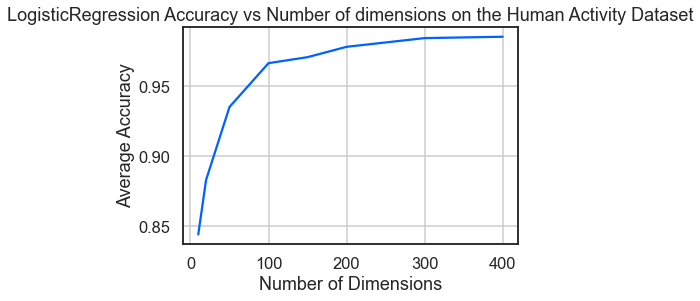

In [27]:
sns.set_context('talk')

ax = plt.axes()
ax.plot(ns, score_list)
ax.set(xlabel='Number of Dimensions',
       ylabel='Average Accuracy',
       title='LogisticRegression Accuracy vs Number of dimensions on the Human Activity Dataset')
ax.grid(True)

---
### Machine Learning Foundation (C) 2020 IBM Corporation